In [1]:
import numpy as np

In [2]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

import keras_unet

Using TensorFlow backend.


In [3]:
from sklearn.preprocessing import StandardScaler

def standardize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def prepare_data(X, y):
    
    X_reshaped = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
    X_std = standardize(X_reshaped)
    X_prepared = X_std.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    y_prepared = y.reshape(y.shape[0], y.shape[1], 1)

    return X_prepared, y_prepared

## Loading trained U-Net weights

In [4]:
from keras.models import load_model

dependencies = { 'iou': iou }

# load model
model = load_model('../models/segm_model_v3.h5', custom_objects=dependencies)
model.summary()

W0929 18:26:40.864546 140736150578048 deprecation_wrapper.py:119] From /Users/sophieroginsky/anaconda3/envs/insight/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0929 18:26:40.900861 140736150578048 deprecation_wrapper.py:119] From /Users/sophieroginsky/anaconda3/envs/insight/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0929 18:26:40.926162 140736150578048 deprecation_wrapper.py:119] From /Users/sophieroginsky/anaconda3/envs/insight/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 18:26:40.926821 140736150578048 deprecation_wrapper.py:119] From /Users/sophieroginsky/anaconda3/envs/insight/lib/python3.7/site-packages/keras/backend/tensorflow_b

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 512, 512, 13) 0                                            
__________________________________________________________________________________________________
conv2d_438 (Conv2D)             (None, 512, 512, 32) 3776        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_109 (BatchN (None, 512, 512, 32) 128         conv2d_438[0][0]                 
__________________________________________________________________________________________________
dropout_104 (Dropout)           (None, 512, 512, 32) 0           batch_normalization_109[0][0]    
__________________________________________________________________________________________________
conv2d_439

## Loading York county data

In [5]:
import matplotlib.pyplot as plt

207424.06680933334

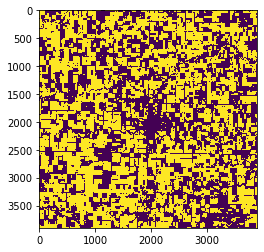

In [7]:
york_img = np.load('../data/processed/york_county/york_img_.npy')
york_mask = np.load('../data/processed/york_county/york_mask_.npy')

plt.imshow(york_mask[:3900,:3900])

# TODO: function to calculate acerage based on pixels
# (np.count_nonzero(york_mask[:3900,:3900]))/9)*0.222394)

In [8]:
X, y = prepare_data(york_img[:3900,:3900], york_mask[:3900,:3900])

## Get smaller patches/crops from bigger image

In [22]:
from PIL import Image
import numpy as np
from keras_unet.utils import get_patches, reconstruct_from_patches

patch_size = 512
stride_size = 256

x_patch = get_patches(
    img_arr=X, # required - array of images to be cropped
    size=patch_size,
    stride=stride_size)

y_patch = get_patches(
  img_arr=y, 
  size=patch_size, 
  stride=stride_size)

## Making predictions

In [25]:
y_pred = model.predict(x_patch)

In [26]:
y_pred_binary = np.round_(y_pred, 0)

## Results

In [27]:
# Intersection-over-union
# Common metric for image segmentation problems

def iou(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    iou = tp / (tp + fn + fp)
    return iou

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

confusion_mat = confusion_matrix(y_patch.flatten(), y_pred_binary.flatten())

print('Accuracy: %.2f' % accuracy_score(y_patch.flatten(), y_pred_binary.flatten()))
print('Intersection-over-Union: %.2f' % iou(confusion_mat))
print('Confusion Matrix: \n', confusion_mat)
print('Classification report:\n', classification_report(y_patch.flatten(), y_pred_binary.flatten()))

Accuracy: 0.94
Intersection-over-Union: 0.90
Confusion Matrix: 
 [[22211057   625612]
 [ 2267433 26276122]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94  22836669
           1       0.98      0.92      0.95  28543555

    accuracy                           0.94  51380224
   macro avg       0.94      0.95      0.94  51380224
weighted avg       0.95      0.94      0.94  51380224



## Prediction Visualizations

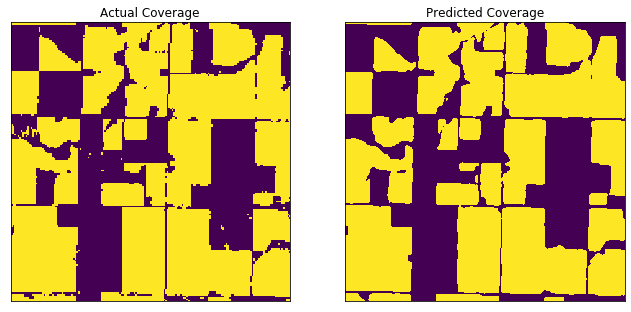

In [33]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(11,6))

plt.subplot(121)
plt.title('Actual Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_patch[1].reshape(512, 512))

plt.subplot(122)
plt.title('Predicted Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_pred_binary[1].reshape(512, 512))

## Reconstructed predicted image

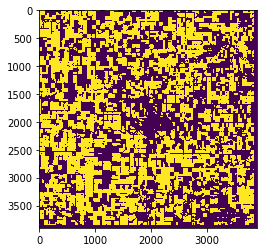

In [34]:
y_pred_reconstructed = reconstruct_from_patches(
    img_arr=y_pred_binary,
    org_img_size=(y.shape[0], y.shape[1]),
    size=patch_size,
    stride=stride_size
    )

plt.imshow(y_pred_reconstructed.reshape(3900, 3900))

## Plotting predicted labels over image

In [116]:
def plot_image(image, factor=1, filename=None):
    """
    Utility function for plotting RGB images.
    """
#     fig = plt.subplots(nrows=1, ncols=1, figsize=(20,20))

    plt.xticks([])
    plt.yticks([])
        
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
def plot_image_labels(image, labels, factor=1, filename=None):

    # setting 0 values to NaN for transparent plotting
    labels_nan = labels.astype('float')
    labels_nan[labels_nan == 0] = np.nan
    
#     fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    plt.xticks([])
    plt.yticks([])
        
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
        plt.imshow(labels_nan, cmap='cividis_r', alpha=1)
    else:
        plt.imshow(image)
        plt.imshow(labels_nan, cmap='cividis_r', alpha=1)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

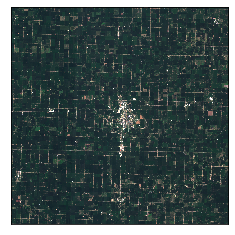

In [119]:
# Satellite image of area of interest

plot_image(york_img[:3845,:3845,[3,2,1,]], 5)

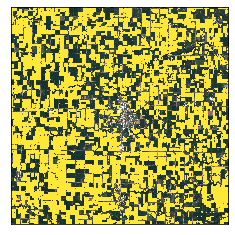

In [118]:
# Predicted corn crop labels over image

plot_image_labels(york_img[:3845,:3845,[3,2,1,]], y_pred_reconstructed.reshape(3900, 3900)[:3845,:3845], 5)